In [1]:
### SKIP THIS CELL ###
import pandas as pd

def summarize_dataset_dims(datasets, dataset_names=None):
    summary = []

    for i, ds in enumerate(datasets):
        name = (
            ds.attrs.get("cat:source", f"dataset_{i}")
            if dataset_names is None
            else dataset_names[i]
        )
        dims_summary = {"dataset": name}

        for dim in ds.dims:
            try:
                values = ds[dim].values
                if values.ndim == 1 and len(values) > 0:
                    dims_summary[f"{dim}_min"] = values.min()
                    dims_summary[f"{dim}_max"] = values.max()
                else:
                    dims_summary[f"{dim}_min"] = None
                    dims_summary[f"{dim}_max"] = None
            except Exception as e:
                dims_summary[f"{dim}_min"] = None
                dims_summary[f"{dim}_max"] = None

        summary.append(dims_summary)

    return pd.DataFrame(summary)


In [2]:
### SKIP THIS CELL ###
"""Workflow to extract obs data."""
import atexit
import logging
import os

import numpy as np
import xarray as xr

from dask import config as dskconf
from dask.distributed import Client

import xclim
from xclim.core import units

import xscen as xs
from xscen.config import CONFIG

import xsdba

import geopandas as gpd

# Load configuration
xs.load_config(
    "paths_obs.yml", "config_obs.yml", verbose=(__name__ == "__main__"), reset=True
)

# get logger
if "logging" in CONFIG:
    logger = logging.getLogger("xscen")

def clean_for_zarr(ds: xr.Dataset) -> xr.Dataset:
    """Clean dataset for Zarr saving: fix encodings and rechunk any multi-chunk variable."""
    for var in ds.variables:
        ds[var].encoding.pop("chunks", None)

        da = ds[var]
        if hasattr(da, "chunks") and da.chunks is not None:
            # If any dimension has multiple chunks, rechunk fully
            if any(len(dim_chunks) > 1 for dim_chunks in da.chunks):
                ds[var] = da.chunk({dim: -1 for dim in da.dims})

    return ds

if __name__ == "__main__":
    # set dask  configuration
    daskkws = CONFIG["dask"].get("client", {})
    dskconf.set(**{k: v for k, v in CONFIG["dask"].items() if k != "client"})

    # set xclim config to compute indicators on 3H data FixMe: can this be removed?
    xclim.set_options(**CONFIG["set_options"])

    # set email config
    if "scripting" in CONFIG:
        atexit.register(xs.send_mail_on_exit, subject=CONFIG["scripting"]["subject"])

    # initialize Project Catalog (only do this once, if the file doesn't already exist)
    if not os.path.exists(CONFIG["paths"]["project_catalog"]):
        pcat = xs.ProjectCatalog.create(
            CONFIG["paths"]["project_catalog"],
            project=CONFIG["project"],
        )
        # add a column to allow searching during performance task
        pcat.df['performance_base']=[np.nan]*len(pcat.df)
        pcat.update()

    # load project catalog
    pcat = xs.ProjectCatalog(CONFIG["paths"]["project_catalog"])



    # set some recurrent variables
    if CONFIG.get("to_dataset_dict", False):
        tdd = CONFIG["to_dataset_dict"]

In [3]:
def spatial_ccc_map(a: xr.DataArray, b: xr.DataArray) -> xr.DataArray: # Computes Concordance Correlation Coefficient
    # Select only the times that appear in both data sets
    common_times = np.intersect1d(a.time.values, b.time.values)
    a_aligned = a.sel(time=common_times)
    b_aligned = b.sel(time=common_times)

    # Mean and variance per grid cell
    mean_a = a_aligned.mean(dim="time")
    mean_b = b_aligned.mean(dim="time")
    var_a = a_aligned.var(dim="time")
    var_b = b_aligned.var(dim="time")

    # Pearson correlation per grid cell
    corr = xr.corr(a_aligned, b_aligned, dim="time")

    # Computing CCC
    numerator = 2 * corr * np.sqrt(var_a) * np.sqrt(var_b)
    denominator = var_a + var_b + (mean_a - mean_b) ** 2
    return numerator / denominator


In [4]:
# --- COHERENCE ---

if "coherence" in CONFIG["tasks"]:
    for search_param_dict in CONFIG["coherence"]["inputs"]:
        print(f"Checking: {search_param_dict}")
        ds_dict = pcat.search(**search_param_dict).to_dataset_dict()

        # Normalize rlon for the datasets that include it
        for ds in ds_dict.values():
            if "rlon" in ds.dims:
                ds["rlon"] = (ds["rlon"] % 360).assign_attrs(ds["rlon"].attrs)

        # Extract variable names
        var_lists = [set(ds.data_vars) for ds in ds_dict.values()]
        variables = var_lists[0]
        all_match = all(v == variables for v in var_lists[1:])
        if not all_match:
            shared_vars = set.intersection(*var_lists)
            missing_sets = [
                (name, vars_ - shared_vars)
                for (name, vars_) in zip(ds_dict.keys(), var_lists)
                if vars_ != shared_vars
            ]
            missing_msg = "\n".join(
                f"- {name} is missing {sorted(list(missing))}" for name, missing in missing_sets
            )
            raise ValueError(
                f"Datasets do not all contain the same variable(s): {search_param_dict}\n"
                f"Shared variable(s): {sorted(list(shared_vars))}\n"
                f"Inconsistencies:\n{missing_msg}"
            )

        # Check CRS consistency
        crs_list = [ds.crs for ds in ds_dict.values()]
        if len(set(crs_list)) > 1:
            raise ValueError("Unsure if this case matters")  # TODO: Investigate

        # Separate by grid type
        regular_grid = []
        rotated_grid = []
        for ds in ds_dict.values():
            if "rlat" in ds.dims:
                rotated_grid.append(ds)
            else:
                regular_grid.append(ds)

        # Regrid all datasets except the chosen grid
        if rotated_grid:
            target_grid = rotated_grid[0]
        elif regular_grid:
            target_grid = regular_grid[0]
        else:
            raise ValueError("No datasets found to define a target grid.")

        all_datasets = []
        for ds in ds_dict.values():
            if ds is target_grid:
                all_datasets.append(ds)
            else:
                all_datasets.append(xs.regrid_dataset(ds, target_grid))

        # Compute CCC maps
        from itertools import combinations

        ccc_maps = {}

        for var in variables:
            print(f"\n--- Computing CCC map for variable: {var} ---")
            for (name1, ds1), (name2, ds2) in combinations(zip(ds_dict.keys(), all_datasets), 2):
                ccc_map = spatial_ccc_map(ds1[var], ds2[var])

                # Set output attributes (basic metadata)
                ccc_map.attrs["long_name"] = "Concordance Correlation Coefficient"
                ccc_map.attrs["description"] = f"{var}\n{ds1.attrs['cat:source']} vs {ds2.attrs['cat:source']}"
                key = (var, name1, name2)
                ccc_maps[key] = ccc_map


Checking: {'variable': ['tg_mean_annual'], 'type': 'reconstruction', 'source': ['EMDNA', 'ERA5-Land', 'PCICBlend']}

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


KeyError: "No variable named 'crs'. Variables on the dataset include ['tg_mean_annual', 'lat', 'lon', 'time']"

### Le plus que c'est foncé, le mieux que c'est

/exec/abuyalo/.conda/envs/obsflow_copy/lib/python3.12/site-packages/figanos/matplotlib/utils.py:227: UserWarning: Attribute "units" not found.
/exec/abuyalo/.conda/envs/obsflow_copy/lib/python3.12/site-packages/figanos/matplotlib/utils.py:227: UserWarning: Attribute "units" not found.
/exec/abuyalo/.conda/envs/obsflow_copy/lib/python3.12/site-packages/figanos/matplotlib/utils.py:227: UserWarning: Attribute "units" not found.
/exec/abuyalo/.conda/envs/obsflow_copy/lib/python3.12/site-packages/figanos/matplotlib/utils.py:227: UserWarning: Attribute "units" not found.
/exec/abuyalo/.conda/envs/obsflow_copy/lib/python3.12/site-packages/figanos/matplotlib/utils.py:227: UserWarning: Attribute "units" not found.
/exec/abuyalo/.conda/envs/obsflow_copy/lib/python3.12/site-packages/figanos/matplotlib/utils.py:227: UserWarning: Attribute "units" not found.
/exec/abuyalo/.conda/envs/obsflow_copy/lib/python3.12/site-packages/figanos/matplotlib/utils.py:227: UserWarning: Attribute "units" not found.

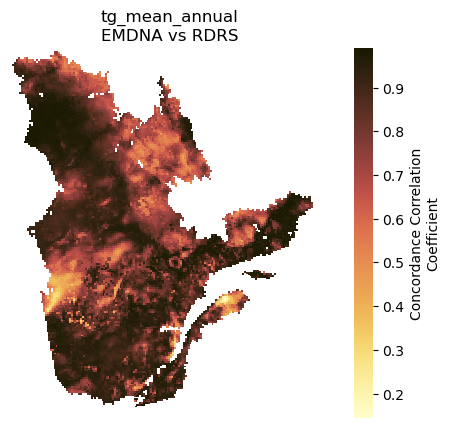

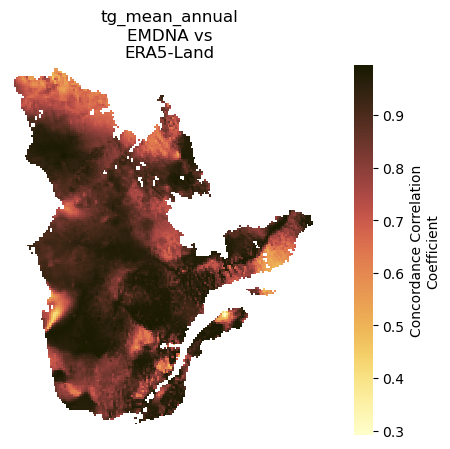

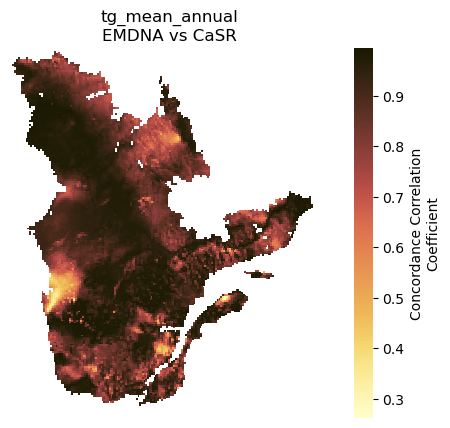

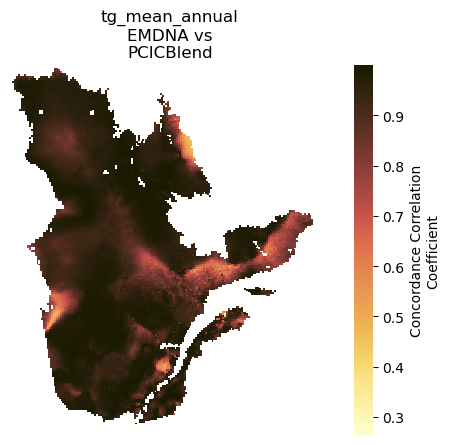

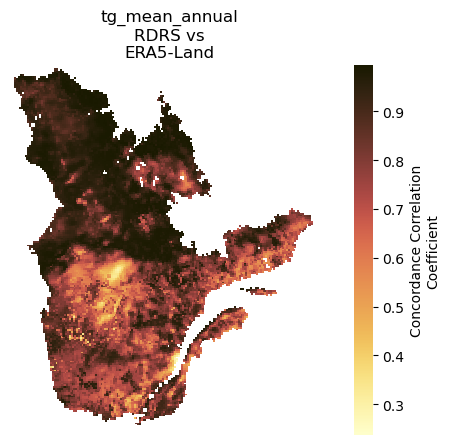

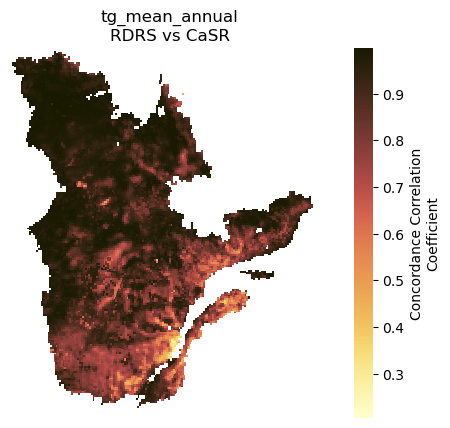

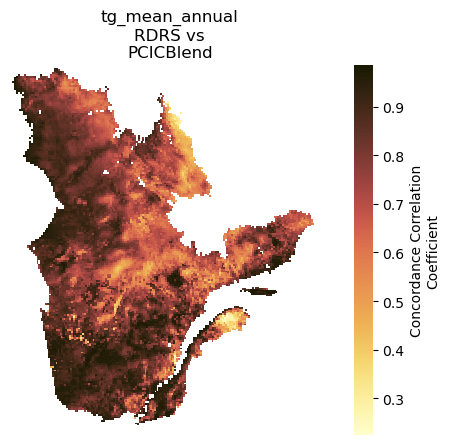

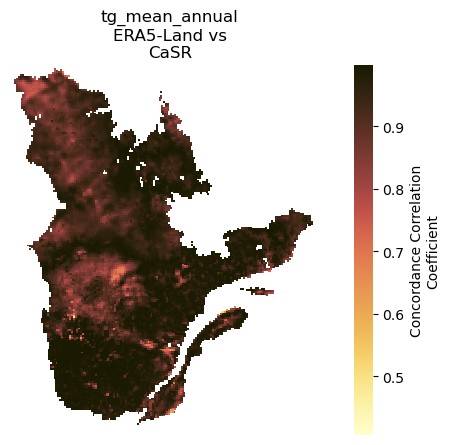

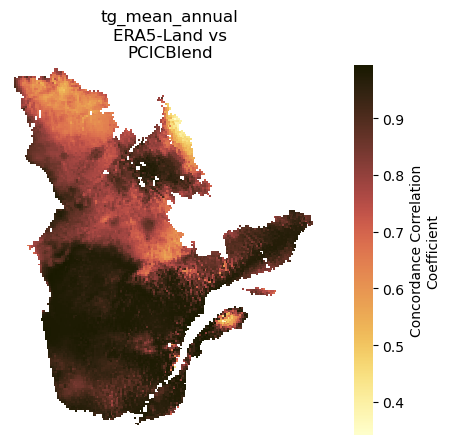

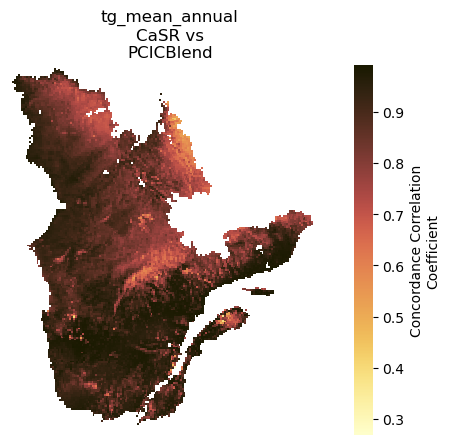

In [ ]:
import figanos.matplotlib as fg
for ccc_map in ccc_maps.values():
    fg.gridmap(ccc_map)

In [ ]:
df = summarize_dataset_dims(all_datasets)
print(df)

     dataset   time_min   time_max  rlat_min  rlat_max  rlon_min   rlon_max
0  ERA5-Land 1980-01-01 2025-01-01    -11.52       5.4  6.632782  21.122787
1  PCICBlend 1980-01-01 2012-01-01    -11.52       5.4  6.632782  21.122787
2      EMDNA 1980-01-01 2018-01-01    -11.52       5.4  6.632782  21.122787
3       CaSR 1980-01-01 2023-01-01    -11.52       5.4  6.632782  21.122787
4       RDRS 1980-01-01 2018-01-01    -11.52       5.4  6.632782  21.122787


In [ ]:
print(summarize_dataset_dims(rotated_grid))

  dataset   time_min   time_max  rlat_min  rlat_max  rlon_min   rlon_max
0    CaSR 1980-01-01 2023-01-01    -11.52       5.4  6.632782  21.122787
1    RDRS 1980-01-01 2018-01-01    -11.52       5.4  6.632782  21.122772


In [ ]:
#fg.gridmap(all_datasets[0].isel(time=0))

In [ ]:
ds_dict["GovCan_CaSR_NAM_reconstruction.Quebec.indicators.YS-JAN"]

<xarray.Dataset> Size: 6MB
Dimensions:         (time: 44, rlat: 189, rlon: 162)
Coordinates:
    lat             (rlat, rlon) float32 122kB dask.array<chunksize=(189, 162), meta=np.ndarray>
    lon             (rlat, rlon) float32 122kB dask.array<chunksize=(189, 162), meta=np.ndarray>
  * rlat            (rlat) float32 756B -11.52 -11.43 -11.34 ... 5.22 5.31 5.4
  * rlon            (rlon) float32 648B 6.633 6.723 6.813 ... 20.94 21.03 21.12
    rotated_pole    |S1 1B ...
  * time            (time) datetime64[ns] 352B 1980-01-01 ... 2023-01-01
Data variables:
    tg_mean_annual  (time, rlat, rlon) float32 5MB dask.array<chunksize=(44, 189, 162), meta=np.ndarray>
Attributes: (12/40)
    Conventions:             CF-1.8
    Remarks:                 Original variable names are following the conven...
    contact:                 
    crs:                     EPSG:4326
    doi:                     https://doi.org/10.5194/hess-25-4917-2021
    frequency:               day
    ...                      ...
    cat:domain:              Quebec
    cat:date_start:          1980-01-01 00:00:00
    cat:date_end:            2023-01-01 00:00:00
    cat:version:             v31
    cat:_data_format_:       zarr
    cat:path:                /tank/jlavoie/abuyalo/obsflow/indicators/GovCan_...

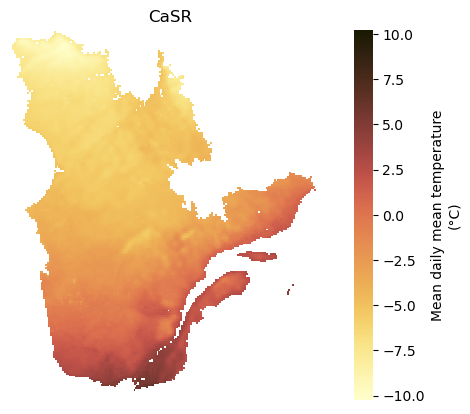

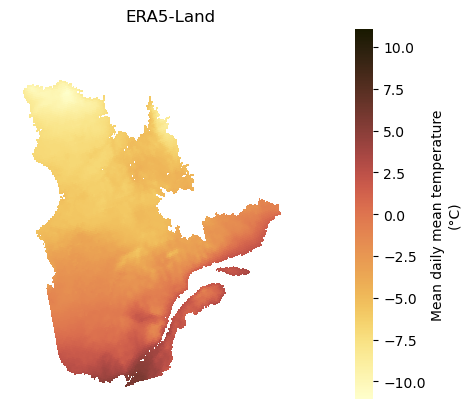

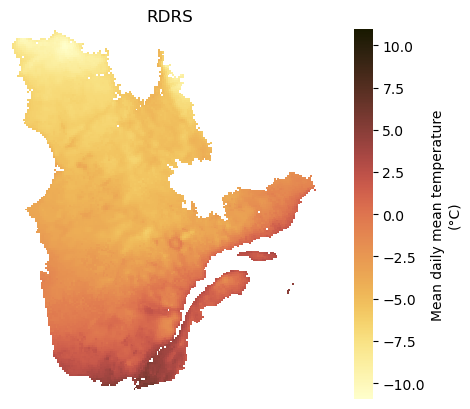

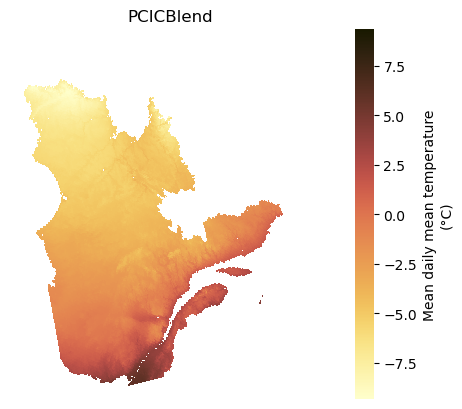

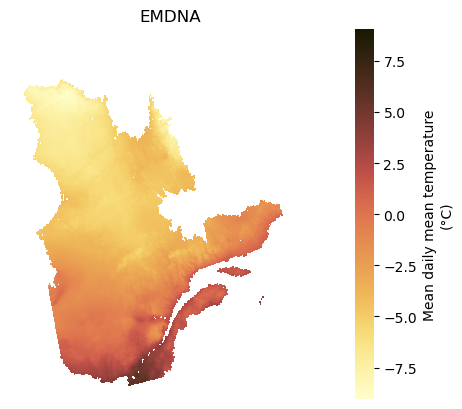

In [ ]:
for ds in ds_dict.values():
    ax = fg.gridmap(ds[var].isel(time=0))
    ax.set_title(ds.attrs["cat:source"])

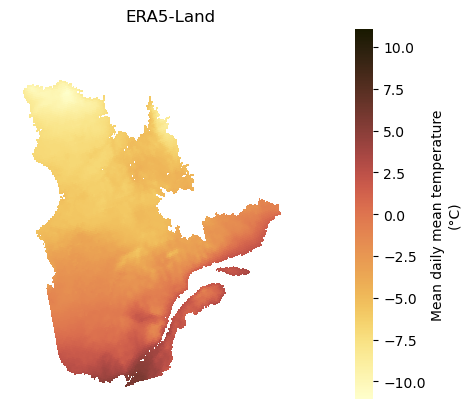

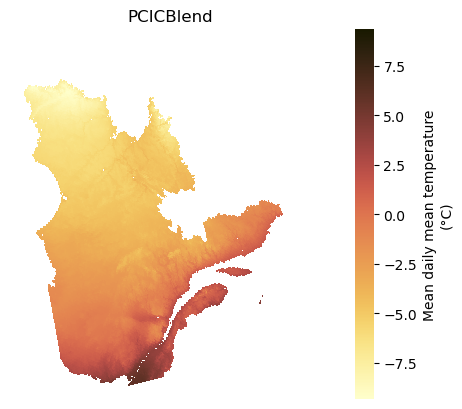

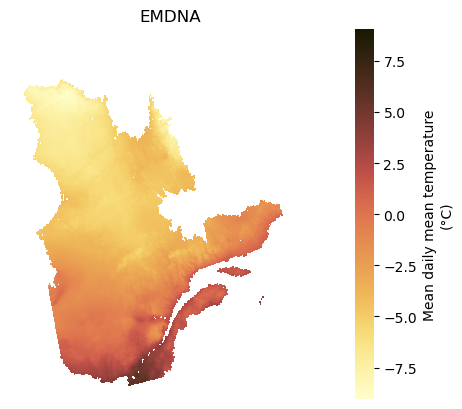

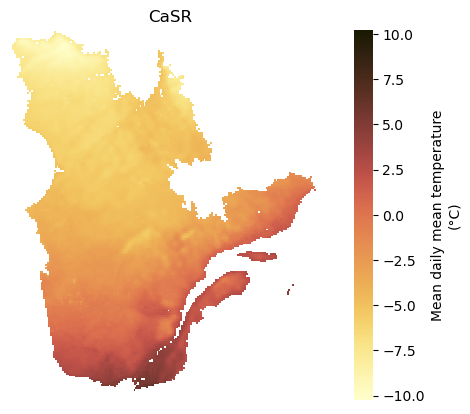

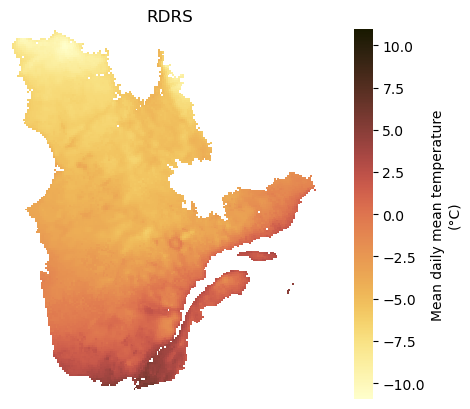

In [ ]:
for ds in TEMP_all_datasets:
    ax = fg.gridmap(ds[var].isel(time=0))
    ax.set_title(ds.attrs["cat:source"])

In [ ]:
for ds in all_datasets:
    print(ds.dims)

FrozenMappingWarningOnValuesAccess({'time': 46, 'rlat': 189, 'rlon': 162})
FrozenMappingWarningOnValuesAccess({'time': 33, 'rlat': 189, 'rlon': 162})
FrozenMappingWarningOnValuesAccess({'time': 39, 'rlat': 189, 'rlon': 162})
FrozenMappingWarningOnValuesAccess({'time': 44, 'rlat': 189, 'rlon': 162})
FrozenMappingWarningOnValuesAccess({'time': 39, 'rlat': 189, 'rlon': 162})


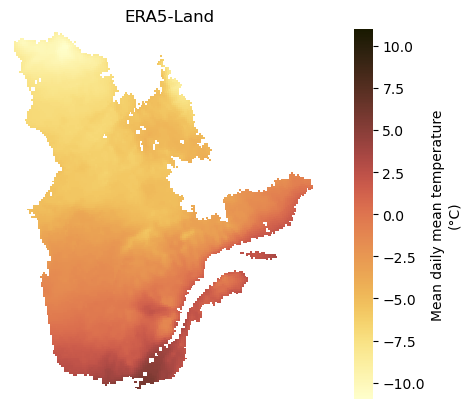

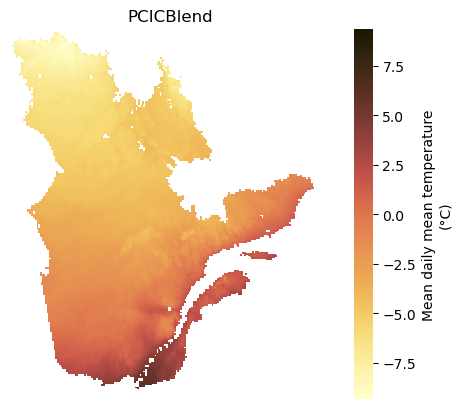

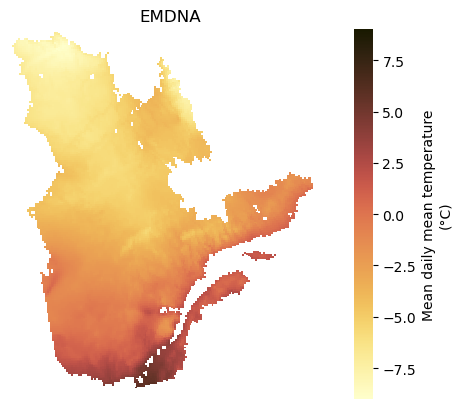

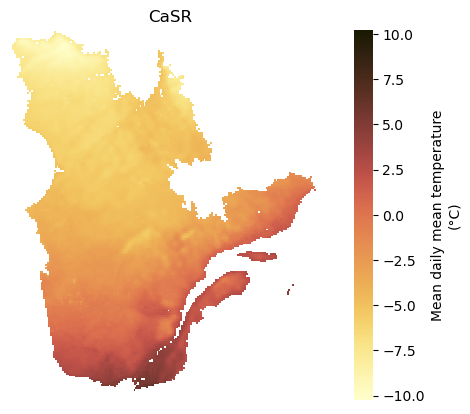

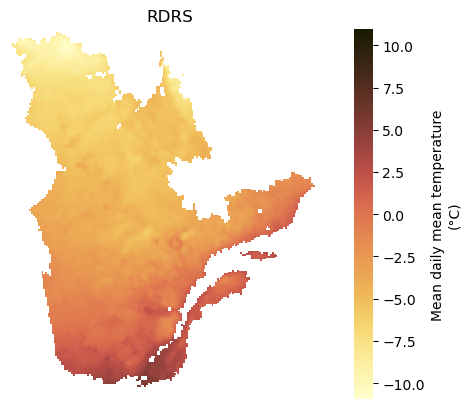

In [ ]:
for ds in all_datasets:
    ax = fg.gridmap(ds[var].isel(time=0))
    ax.set_title(ds.attrs["cat:source"])

In [ ]:
target_grid.attrs["cat:source"]

'CaSR'